<p align="center">
<img style="width:60%" src="http://www.clipartbest.com/cliparts/yio/LdA/yioLdA9eT.jpg">
</p>

[Image source](http://www.clipartbest.com/clipart-yioLdA9eT)

<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">House prices.<br> Part 2. Neural networks.</h1>

## Please use nbviewer to read this notebook to use all it's features:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/Regression/HousePrice/01%20EDA.ipynb

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>


## 1.	[Feature engineering.](#Step1)
## 1.1. [Fill missing data.](#Step1.1)
## 1.2. [Generate new features.](#Step1.2)
## 1.3. [Feature encoding.](#Step1.3)
## 1.4. [Feature scaling.](#Step1.4)
## 2. [Fit and score the model.](#Step2)
## 3. [Make predictions and generate a submission.](#Step3)

In [41]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import Loss
from tensorflow.python.ops.math_ops import log, cast, squared_difference, \
    sqrt, div_no_nan
from tensorflow.python.keras.utils import losses_utils
from tensorflow.keras import backend
from tensorflow import constant, shape, math

pd.options.display.max_rows = 80

<div id="Step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1. Feature engineering.</span>

## Load data

In [42]:
dataset_train = pd.read_csv('Data/train.csv', index_col=0)
dataset_test = pd.read_csv('Data/test.csv', index_col=0)

## Create full dataset (both train and test)

In [43]:
dataset_full = pd.concat([dataset_train, dataset_test])
dataset_full.shape

(2919, 80)

## Split data into categorical and numerical features.

In [44]:
categorical_features = \
    ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
     'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
     'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
     'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
     'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
     'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
     'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
     'MiscFeature', 'SaleType', 'SaleCondition']

numerical_features = \
    ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',  'MasVnrArea',
     'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
     '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
     'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
     'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
     'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

print(f'Total features:       {len(dataset_full.columns)}\n'
      f'Categorical features: {len(categorical_features)}\n'
      f'Numerical features:   {len(numerical_features)}\n'
      f'Dependent variable:   1')


Total features:       80
Categorical features: 44
Numerical features:   35
Dependent variable:   1


<div id="Step1.1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1.1. Fill missing data.</span>

## Fill missing data

In [45]:
missing = dataset_full.drop('SalePrice', axis=1).isna().sum().sum()
print(f'Missing values before imputing: {missing}')

Missing values before imputing: 13965


In [46]:
CATEGORICAL_NA = 'No'
categorical_features_to_fill = ['PoolQC', 'Fence', 'MiscFeature',
                                'FireplaceQu', 'Alley', 'MasVnrType']
numerical_features_to_fill = ['GarageYrBlt', 'GarageCars', 'GarageArea',
                              'MasVnrArea']

dataset_full['LotFrontage'].fillna(dataset_full['LotFrontage'].mean(),
                                   inplace=True)
dataset_full['Electrical'].fillna('SBrkr', inplace=True)
dataset_full['Functional'].fillna('Typ', inplace=True)
dataset_full['KitchenQual'].fillna('TA', inplace=True)
dataset_full['MSZoning'].fillna('RL', inplace=True)
dataset_full['SaleType'].fillna('WD', inplace=True)
dataset_full['Utilities'].fillna('AllPub', inplace=True)
dataset_full['Exterior1st'].fillna('Wd Sdng', inplace=True)
dataset_full['Exterior2nd'].fillna('MetalSd', inplace=True)
dataset_full['PoolQC'].fillna('Gd', inplace=True)

# Basement
basement_categorical = ['BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
                        'BsmtCond', 'BsmtExposure']
categorical_features_to_fill += basement_categorical

basement_numerical = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                      'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
dataset_full[basement_numerical] = dataset_full[basement_numerical].fillna(0)

# Garage
dataset_full['GarageYrBlt'].replace(2207, 2007, inplace=True)
garage_categorical = ['GarageType', 'GarageFinish', 'GarageQual',
                      'GarageCond']
# Fill categorical features with 'No'
categorical_features_to_fill += garage_categorical
dataset_full[categorical_features_to_fill] = \
    dataset_full[categorical_features_to_fill].fillna(CATEGORICAL_NA)

# Fill numerical features with 0
dataset_full[numerical_features_to_fill] = \
    dataset_full[numerical_features_to_fill].fillna(0)

In [47]:
missing = dataset_full.drop('SalePrice', axis=1).isna().sum().sum()
print(f'Missing values after imputing: {missing}')

Missing values after imputing: 0


<div id="Step1.2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1.2. Generate new features.</span>

Features derived from age of the building.

In [48]:
dataset_full['BuildingAge'] = dataset_full['YrSold'] - dataset_full['YearBuilt']
dataset_full['BuildingAge'] = np.where(dataset_full['BuildingAge'] > 0,
                                   dataset_full['BuildingAge'], 0)
numerical_features.append('BuildingAge')

dataset_full['RemodelledAge'] = dataset_full['YrSold'] - dataset_full[
    'YearRemodAdd']
dataset_full['RemodelledAge'] = np.where(dataset_full['RemodelledAge'] > 0,
                                     dataset_full['RemodelledAge'], 0)
numerical_features.append('RemodelledAge')
dataset_full['GarageAge'] = np.where(dataset_full['GarageYrBlt'] == 0, 0,
                                 dataset_full['YrSold'] - dataset_full[
                                     'GarageYrBlt'])
dataset_full['GarageAge'] = np.where(dataset_full['GarageAge'] < 0, 0,
                                 dataset_full['GarageAge'])
numerical_features.append('GarageAge')

In [49]:
dataset_full['BeforeCrisis'] = np.where(dataset_full['YrSold'] < 2010, 1, 0)
categorical_features.append('BeforeCrisis')

## Number of Storeys

In [50]:
floors = {20: 1, 30: 1, 40: 1, 45: 1, 50: 1, 60: 2, 70: 2, 75: 2, 80: 2,
          85: 2, 90: 2, 120: 1, 150: 1, 160: 2, 180: 2, 190: 2}
dataset_full['Floors'] = dataset_full['MSSubClass'].map(floors)
categorical_features.append('Floors')

## Features from area of the building

In [51]:
dataset_full['TotalAreaSF'] = dataset_full['GrLivArea'] \
                          + dataset_full['TotalBsmtSF']
numerical_features.append('TotalAreaSF')

dataset_full['BasementFinishedPercent'] = \
    (dataset_full['TotalBsmtSF'] - dataset_full['BsmtUnfSF']) / dataset_full[
        'TotalBsmtSF']
dataset_full['BasementFinishedPercent'].fillna(0, inplace=True)
numerical_features.append('BasementFinishedPercent')

In [52]:
dataset_full['TotalAreaSFBinned'] = \
    pd.cut(dataset_full['TotalAreaSF'], bins=30, right=True).cat.codes
categorical_features.append('TotalAreaSFBinned')

## Year of sale

In [53]:
dataset_full['Year'] = dataset_full['YrSold'].map(
    {2006: 1, 2007: 2, 2008: 3, 2009: 4, 2010: 5})
categorical_features.append('Year')

## Turn some categorical features into numerical features

In [54]:
condition_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0,
                  'No': 0}

In [55]:
columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
           'KitchenQual', 'FireplaceQu', 'GarageQual', 'PoolQC', 'GarageCond']
for column in columns:
    new_column_name = column + 'Num'
    dataset_full[new_column_name] = dataset_full[column].map(condition_dict)
    numerical_features.append(new_column_name)

## Turn some categorical features into numerical features

In [56]:
condition_dict = {'Gd': 3, 'Av': 2, 'Mn': 1, 'NA': 0, 'No': 0,
                  'No Basement': 0}

dataset_full['BsmtExposureNum'] = dataset_full['BsmtExposure'].map(
    condition_dict)
numerical_features.append('BsmtExposureNum')

condition_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2,
                  'Unf': 1, 'NA': 0, 'No': 0}

dataset_full['BsmtFinType1Num'] = dataset_full['BsmtFinType1'].map(
    condition_dict)
numerical_features.append('BsmtFinType1Num')

dataset_full['BsmtFinType2Num'] = dataset_full['BsmtFinType2'].map(
    condition_dict)
numerical_features.append('BsmtFinType2Num')

condition_dict = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'No': 0, 'NA': 0}
dataset_full['GarageFinishNum'] = dataset_full['GarageFinish'].map(
    condition_dict)
numerical_features.append('GarageFinishNum')

condition_dict = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'No': 0}
dataset_full['FenceNum'] = dataset_full['Fence'].map(condition_dict)
numerical_features.append('FenceNum')

## Composed features

In [57]:
dataset_full['OverallQualOverallCond'] = dataset_full['OverallQual'] + dataset_full[
    'OverallCond']
numerical_features.append('OverallQualOverallCond')

dataset_full['RoomSize'] = \
    dataset_full['GrLivArea'] + dataset_full['TotRmsAbvGrd']
numerical_features.append('RoomSize')

dataset_full['SumAge'] = (dataset_full['BuildingAge'] + dataset_full[
    'RemodelledAge'])
numerical_features.append('SumAge')

dataset_full['OverallQualTotalAreaSFMultiplied'] = \
    dataset_full['OverallQual'] * dataset_full['TotalAreaSF']
numerical_features.append('OverallQualTotalAreaSFMultiplied')

dataset_full['QualSquared'] = \
    np.square(dataset_full['OverallQual'].astype(np.int64))
numerical_features.append('QualSquared')

In [58]:
# Sort the features list
numerical_features = sorted(numerical_features)

## Remove categorical features replaced by numerical ones.

In [59]:
replaced_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
                     'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
dataset_full.drop(replaced_features, axis=1, inplace=True)
for feature in replaced_features:
    categorical_features.remove(feature)
dataset_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,BsmtExposureNum,BsmtFinType1Num,BsmtFinType2Num,GarageFinishNum,FenceNum,OverallQualOverallCond,RoomSize,SumAge,OverallQualTotalAreaSFMultiplied,QualSquared
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,Inside,...,0,6,1,2,0,12,1718,10,17962.0,49
2,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,FR2,...,3,5,1,2,0,14,1268,62,15144.0,36
3,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,Inside,...,1,6,1,2,0,12,1792,13,18942.0,49
4,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,Corner,...,0,5,1,1,0,12,1724,127,17311.0,49
5,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,FR2,...,2,6,1,2,0,13,2207,16,26744.0,64


<div id="Step1.3">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1.3. Feature encoding.</span>

## One-hot encoding

In [60]:
dataset_full_encoded = pd.get_dummies(dataset_full,
                                      columns=categorical_features)
dataset_full_encoded.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,TotalAreaSFBinned_16,TotalAreaSFBinned_17,TotalAreaSFBinned_19,TotalAreaSFBinned_25,TotalAreaSFBinned_29,Year_1,Year_2,Year_3,Year_4,Year_5
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,0,0,0,0,1,0,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,0,0,0,1,0,0,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,0,0,0,0,1,0,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,0,0,1,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,0,0,0,0,1,0,0


## Split into the train and the test sets.

In [61]:
train_mask = dataset_full['SalePrice'].isna() == False
pred_mask = dataset_full['SalePrice'].isna() == True
dataset_encoded = dataset_full_encoded[train_mask]
dataset_test_encoded = dataset_full_encoded[pred_mask]

In [62]:
X = dataset_encoded.drop('SalePrice', axis=1)
y = dataset_encoded['SalePrice']

X_test = dataset_test_encoded.drop('SalePrice', axis=1)
y_pred = dataset_test_encoded['SalePrice']

<div id="Step1.4">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1.4. Feature scaling.</span>

## Feature scaling

In [63]:
X_scaler = MinMaxScaler()
X_scaled = pd.DataFrame(X_scaler.fit_transform(X),
                        columns=X.columns,
                        index=X.index)
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test),
                             columns=X_test.columns,
                             index=X_test.index)
dataset_scaled = pd.concat([X_scaled, y], axis=1)
dataset_test_scaled = pd.concat([X_test_scaled, y_pred], axis=1)

# Save scaled data

In [64]:
dataset_scaled.to_csv('Data/train_encoded.csv')
dataset_test_scaled.to_csv('Data/pred_encoded.csv')
print('File saved.')

File saved.


<div id="Step2">
</div>

# <span style="color:#01872A; display: block; padding:10px;background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 2. Fit and score the model.</span>


Function to calculate squared difference of errors, taking into account that
both predictions and ground truth values can be scaled.

In [65]:
def error_squared(y_true, y_pred, scaler, dtype):
    y_true = cast(y_true, dtype)
    y_pred = cast(y_pred, dtype)
    if isinstance(scaler, StandardScaler):
        sc_mean = constant(scaler.mean_, dtype)
        sc_std = constant(scaler.scale_, dtype)
        y_true = y_true * sc_std + sc_mean
        y_pred = y_pred * sc_std + sc_mean
    elif isinstance(scaler, MinMaxScaler):
        sc_min = constant(scaler.min_, dtype)
        sc_scale = constant(scaler.scale_, dtype)
        y_true = (y_true - sc_min) / sc_scale
        y_pred = (y_pred - sc_min) / sc_scale

    y_pred, y_true = \
        losses_utils.squeeze_or_expand_dimensions(y_pred, y_true)
    pred_log = log(backend.maximum(y_pred, backend.epsilon()) + 1.)
    true_log = log(backend.maximum(y_true, backend.epsilon()) + 1.)
    error_sq = squared_difference(pred_log, true_log)
    return error_sq

RootMeanSquaredLogErrorScaled loss function.

In [66]:
class RootMeanSquaredLogErrorScaledLoss(Loss):

    def __init__(self, name="rmsle_custom", dtype='float64', scaler=None):
        super(RootMeanSquaredLogErrorScaledLoss, self).__init__(name=name)
        self.scaler = scaler
        self.dtype = dtype

    def call(self, y_true, y_pred):
        error_sq = error_squared(y_true, y_pred, self.scaler, self.dtype)
        n_values = cast(shape(error_sq)[0], self.dtype)
        return sqrt(math.reduce_sum(error_sq) / n_values)

This is RootMeanSquaredLogErrorScaled metric how it should be.

In [67]:
class RootMeanSquaredLogErrorScaled(Mean):

    def __init__(self, name='rmsle_custom', dtype='float64',
                 scaler=None):
        super(RootMeanSquaredLogErrorScaled, self).__init__(name, dtype=dtype)
        self.scaler = scaler

    def update_state(self, y_true, y_pred, sample_weight=None):
        error_sq = error_squared(y_true, y_pred, self.scaler, self.dtype)
        return super(RootMeanSquaredLogErrorScaled, self).update_state(
            error_sq, sample_weight=sample_weight)

    def result(self):
        return sqrt(div_no_nan(self.total, self.count))

Scoring function and fitting function

In [68]:
def rmsle(y, y_pred):
    if len(y) != len(y_pred):
        return 0
    sum = 0
    for real, pred in zip(y, y_pred):
        # check for negative values
        if real < 0:
            # print('Value below zero!')
            real = 0
        if pred < 0:
            # print('Value below zero!')
            pred = 0
        p = np.log(real + 1)
        r = np.log(pred + 1)
        sum += np.square(p - r)
    result = np.sqrt(sum / len(y_pred))
    if isinstance(result, np.ndarray):
        result = result[0]
    return result

def fit_model(patience, params, X_train, y_train, X_test, y_test):
    tf.random.set_seed(0)
    model = Sequential()
    for _ in range(params['Layers']):
        model.add(Dense(params['Units'], activation='relu'))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam',
                  loss=RootMeanSquaredLogErrorScaledLoss(scaler=y_scaler),
                  metrics=[RootMeanSquaredLogErrorScaled(scaler=y_scaler)])
    if patience is None:
        history = model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=params['Epochs'], verbose=0, batch_size=32)
    else:
        mc = ModelCheckpoint(f'Models/best_model_{patience}.h5',
                             monitor='val_rmsle_custom', mode='min',
                             verbose=0, save_best_only=True)
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0,
                           patience=patience)
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=params['Epochs'], verbose=2,
                            callbacks=[es, mc])
    test_pred = model.predict(X_test, verbose=0)
    if y_scaler:
        test_pred = y_scaler.inverse_transform(test_pred)
    score = rmsle(y_test, test_pred)
    return history, score


In [69]:
X = dataset_scaled.drop('SalePrice', axis=1)
y = dataset_scaled['SalePrice']
X_test = dataset_test_scaled.drop('SalePrice', axis=1)

In [70]:
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.2,  random_state=42)

In [71]:
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))

In [72]:
def learning_curve(history):
    metrics = history.model.metrics_names
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(16, 5))
    if n_metrics == 1:
        axes = [axes]
    for ax, metric in zip(axes, metrics):
        ax.plot(history.history[metric], label=f'Train {metric}')

        val_metric = 'val_' + metric
        if val_metric in history.history:
            ax.plot(history.history[val_metric], label=f'Test {metric}')
        ax.set_title(metric.capitalize(), size=20)
        ax.legend()
    plt.show()

## Define function for model compilation and fitting.
Use callbacks:
1. ModelCheckpoint - to save model with the best results.
2. EarlyStopping   - to prevent overfitting.

In [73]:
def compile_fit_model(model, X_train, y_train, X_test=None, y_test=None,
                      verbose=0, epochs=1000, batch_size=None, patience=200,
                      model_name='Model'):
    tf.random.set_seed(0)
    mc = ModelCheckpoint(f'Models/best_model_{model_name}.h5',
                         monitor='val_rmsle_custom', mode='min',
                         verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose,
                       patience=patience)
    model.compile(optimizer='adam',
              loss=RootMeanSquaredLogErrorScaledLoss(scaler=y_scaler),
              metrics=[RootMeanSquaredLogErrorScaled(scaler=y_scaler)])
    validation_data = (X_test, y_test)
    callbacks = [mc, es]
    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose,
                        validation_data=validation_data,
                        callbacks=callbacks, batch_size=batch_size)
    return model, history

## Fit the model and save the best version with ModelCheckpoint callback

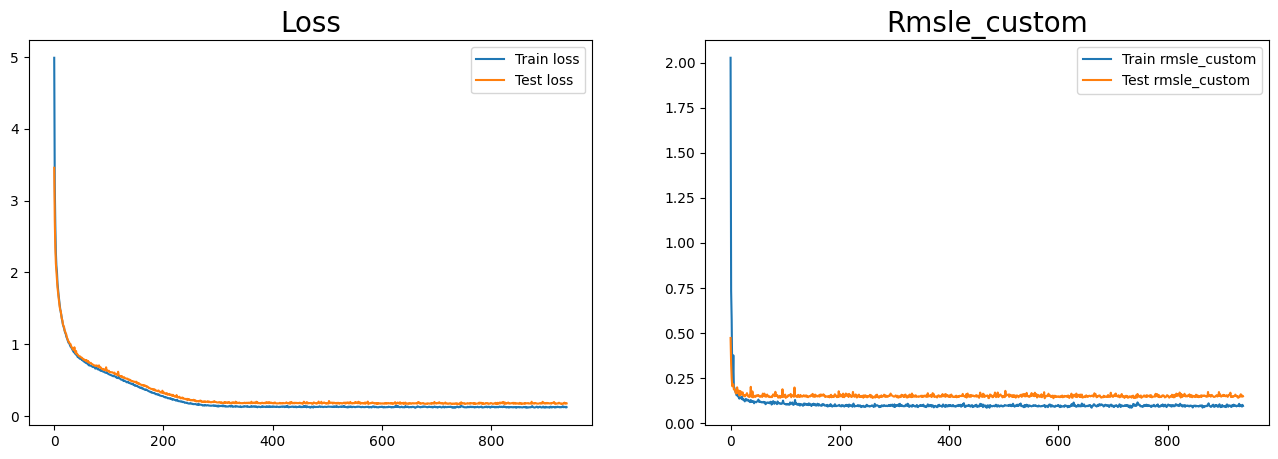

In [74]:
patience = 200
epochs = 1000
model_name = 'Classic'
batch_size = None

model = Sequential()
model.add(Dense(200, activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='linear'))
model, history = \
    compile_fit_model(model, X_train, y_train,  X_val, y_val,
                      verbose=0, epochs=epochs, batch_size=batch_size,
                      patience=patience, model_name=model_name)
learning_curve(history)

## Load and score the best model created by ModelCheckpoint callback.

In [75]:
model = load_model('Models/best_model_Classic.h5', compile=False)
model.compile(optimizer='adam',
              loss=RootMeanSquaredLogErrorScaledLoss(scaler=y_scaler),
              metrics=[RootMeanSquaredLogErrorScaled(scaler=y_scaler)])
model.evaluate(X_val, y_val)

10/10 [==============================] - 0s 1ms/step - loss: 0.1665 - rmsle_custom: 0.1386


[0.16651183366775513, 0.13855284798465167]

<div id="Step3">
</div>

# <span style="color:#01872A; display: block; padding:10px;background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 3. Make predictions and genereate a submission.</span>

## Functions to generate submission

In [76]:
def make_submission(preds, X_test, filename='Submission'):
    submission_df = pd.DataFrame({'SalePrice': preds.reshape(-1)},
                                 index=X_test.index)
    submission_df.sort_index(inplace=True)
    submission_df.to_csv(f'{filename}.csv', index=True)

## Generate validation predictions

In [77]:
train_preds = model.predict(X_val)
train_preds = y_scaler.inverse_transform(train_preds)
train_preds[:5]

array([[140504.05],
       [318271.44],
       [ 89881.73],
       [149473.9 ],
       [321054.8 ]], dtype=float32)

## Generate submission predictions

In [78]:
sub_preds = model.predict(X_test)
sub_preds = y_scaler.inverse_transform(sub_preds)
sub_preds[:5]

array([[120436.41],
       [164586.88],
       [192675.23],
       [202901.52],
       [173106.67]], dtype=float32)

In [79]:
make_submission(sub_preds, X_test, 'Predictions/ScaledANN')

In [80]:
make_submission(train_preds, X_val, 'Predictions/ScaledANNVal')

## [Part 1. EDA.](https://nbviewer.org/github/sersonSerson/Projects/blob/master/Regression/HousePrice/01%20EDA.ipynb)

## [Part 3. Ridge regression.](https://nbviewer.org/github/sersonSerson/Projects/blob/master/Regression/HousePrice/03%20Ridge%20regression.ipynb)

## [Part 4. Ensemble.](https://nbviewer.org/github/sersonSerson/Projects/blob/master/Regression/HousePrice/04%20Ensemble.ipynb)
